# Machine Learning Project 2

In [1]:
# Imports
import pandas as pd
import numpy as np

---
## Generic Functions
Here we define all the functions to be used.

### 1. Data Loading

In [2]:
def load_data(data_path, pos_file, neg_file, size=1_250_000): 

    # positive
    pos = pd.read_table(data_path+pos_file, sep='.\n', names=['tweet'], engine='python')
    pos['label']=1
    print(f"Loaded POS data, correctly interpreted 1-tweet-per-line fashion : {pos.shape[0]==size}")

    # negative
    neg = pd.read_table(data_path+neg_file, sep='.\n', names=['tweet'], engine='python')
    neg['label']=-1
    print(f"Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : {neg.shape[0]==size}")

    # Data sizes
    print(f"Number of tweets : (POS) {pos.shape[0]} (NEG) {neg.shape[0]}\n")

    # Merge datasets to get a complete training set
    tweets = pos.append(neg)
    return tweets

In [3]:
from glove_helper import concatenate

def load_embeddings_and_vocab(embeddings_loc, embeddings_path, vocab_loc, divided=False) :
    
    ## Load word embeddings and vocabulary to compute word vectors of tweets -----------------------------------
    
    # Load word embeddings
    embeddings=None
    if divided : 
        embeddings = concatenate(embeddings_files, embeddings_path)
    else :
        embeddings = np.load(embeddings_path+embeddings_loc)
    print(f'Loaded word embeddings in structure of type {type(embeddings)}.')

    # Loading vocab
    words = pd.read_table(vocab_loc, sep='.\n', names=['word'], engine='python', squeeze=True, na_values=np.nan)
    print(f'Loaded word vocabulary in structure of type {type(words)}.')

    # Check that the vocabulary encompasses all embedded words
    print(f'\nBoth the embeddings and the vocabulary are same length :  {len(embeddings)==words.shape[0]}')
    print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

    ## Clean the data --------------------------------------------------------------------------------------------

    # Drop NaN values in vocab
    nas = words.isna()
    words.dropna(inplace=True)
    # Drop NaN words in embeddings
    embeddings = np.delete(embeddings, nas[nas].index.values, axis=0)
    
    print(f'NaN values were dropped in both tables: {len(embeddings)==words.shape[0]}')
    print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

    ## Process data ---------------------------------------------------------------------------------------------
    
    # Index by words for faster index-for-word search
    words = pd.DataFrame(data=words.index, index=words.values)
    embeddings = pd.DataFrame(embeddings, index=words.index)
    
    return embeddings, words

### 2. Data Resampling

In [4]:
from sklearn.utils import resample

def resample_data(data, size, label=1, seed=None) :
    # Get pos and neg datasets
    pos, neg = data.loc[data['label']==label], data.loc[data['label']!=label]
    
    # Get samples balanced by classes
    n = int(size/2)
    pos_ = resample(pos, n_samples=n, replace=False, random_state=seed)
    neg_ = resample(neg, n_samples=n, replace=False, random_state=seed)
    
    # reform dataset
    data_ = pos_.append(neg_)

    return data_

### 3. Data Embedding

In [5]:
def word_vector(tweet, embeddings, embeddings_dim, vocab, agg_func=None):
    """
    Creates the feature vector corresponding to the tweet.
    To do so, computes the mean of the word embeddings corresponding to the vocabulary words in the tweet.
    
    Parameters 
    ----------
    tweet : str
        Input tweet from which the word vector is created.
    """
    split_by_words = tweet.split()
    embed_list = []
    
    # Get words in tweet that are in vocab
    # Get embeddings for these words
    for w in split_by_words:
        if w in vocab.index :
            embed_list.append(  embeddings.loc[w].values  )
            
    if agg_func is None :
        agg_func = lambda x : np.mean(x, axis=0)
    
    result = None
    # If no vocab word create an empty vector for the tweet
    if not embed_list :
        result = np.zeros(embeddings_dim)
        
    # Else aggregate the word embeddings
    else :
        result = agg_func(embed_list)
    
    # Be sure to output a list to store in dataframe
    if type(result) is not list:
        result = result.tolist()
    
    return result

In [6]:
from glove_helper import concatenate

def load_word_vectors(file_path, file_loc, divided=False): 
    # Load pre-computed word vectors file
    precomputed = None
    if divided :
        print('Loading from divided dataset...')
        precomputed = concatenate(word_vectors_files, file_path)
    else : 
        precomputed = np.load(file_path+file_loc, allow_pickle=True)
        
    precomputed = pd.DataFrame(precomputed, columns=['index', 'label', 'mean_embed'])
    print('Successfully loaded from file!')
    
    return precomputed

In [7]:
from project2_helper import isAdmin, parallelize

def compute_word_vectors(data, embeddings, embeddings_dim, vocab, agg_func=None) :
    data = data.copy()
    
    # compute function to run on tweets
    func = lambda t : word_vector(t, embeddings, embeddings_dim, vocab, agg_func=agg_func)
    
    if isAdmin():
        print('Process is run as admin. Running parallelized computation...')
        data['mean_embed']= parallelize(data['tweet'], func)
    else : 
        print('Process is not run as admin. Cannot run parallelized setting, running as sequential...')
        data['mean_embed']= data['tweet'].map(func)

    return data

In [8]:
def save_word_vectors(data, file_path, ending=None):
    
    # Get word vectors information
    word_vectors = data[['label', 'mean_embed']].reset_index()
    dim = len(word_vectors.loc[0, 'mean_embed'])
    
    # Name file to format : path/word_vectors_xxnsamplesxx_xxembeddimxx_ending_npy
    name = file_path + 'word_vectors_' + str(data.shape[0]) + '_' + str(dim)
    # Add ending if requested
    if ending is not None :
        name = name+'_'+str(ending)
    
    # save data
    np.save(name, word_vectors)
    
    return True

### 4. Data Pre-processing

In [9]:
from sklearn.model_selection import train_test_split

def split_dataset(data, test_size=0.25) : 

    # Split into training and testing data
    train, test = train_test_split(data, test_size=test_size)
    print(f"Local training set size : {train.shape[0]}.")
    print(f"Local testing set size : {test.shape[0]}.\n")
     
    # Create features and labels datasets
    xtrain, ytrain = np.array(train.mean_embed.tolist()), np.array(train.label.to_list())
    xtest, ytest = np.array(test.mean_embed.tolist()), np.array(test.label.tolist())

    print(f'Training sample shape: {xtrain.shape[1:]}')
    print(f'Testing sample shape: {xtest.shape[1:]}')
    
    return xtrain, ytrain, xtest, ytest

In [10]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

def preprocess(X) :
    x=X.copy()
    
    ## Standardize data
    # If features are list of features of different sizes, standardization has to be made list-wise
    if len(np.array(x).shape) == 1 : 
        x = np.array([ StandardScaler().fit_transform(a) for a in x ])
    else :
        x = StandardScaler().fit_transform(x)
    
    ## TODO Polynomial features and interactions
    
    ## other data preprocessing
    
    return x

### 5. Generate submission

In [11]:
# To format the testing data
def extract_tweet(tweet):
    return tweet.split(",", 1)[1]

In [12]:
def get_test_data(data_path, test_file='test_data.txt') :
    # Load the testing data
    test = pd.read_fwf(data_path+test_file, sep="\n", header=None)
    test = test.rename(columns={0:'tweet', 1:'na1', 2:'na2'})

    # Reformating it for submission
    test.index = test.index+1 # Format asked by AI Crowd
    test = test['tweet'].map(extract_tweet).to_frame()

    return test

In [13]:
# Creating submission file
import csv
def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in csv format for submission to kaggle
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})

---

---
## Data pre-training

In [17]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

data_path = '../data/'
pos_data = 'train_pos_full.txt'
neg_data = 'train_neg_full.txt'

precomputed_path = '../precomputed_data/'
vocab_loc = '../data/vocab_cut.txt'
path = '../results/'

data_size = 500_000

def word_vector_creation_automated(embeddings_files):
    
    tweets = load_data(data_path, pos_data, neg_data)
    tweets_ = resample_data(tweets, data_size, seed=1)
    
    for embeddings_file in embeddings_files:
        print(embeddings_file)        
        embeddings, vocab = load_embeddings_and_vocab(embeddings_file, precomputed_path, vocab_loc)

        word_vector = compute_word_vectors(tweets_, embeddings, embeddings.shape[1], vocab) 
        save_word_vectors(word_vector, precomputed_path)
        
        del embeddings
        del vocab
        del word_vector
        
def NN(embeddings_dim_info):
    
    divided_word_vectors = False
    word_vectors_files = "word_vectors_500000_" + str(embeddings_dim_info) + "final.npy"
    
    tweets_ = load_word_vectors(
    precomputed_path, 
    word_vectors_files, 
    divided=divided_word_vectors)
    
    #### BASELINE : Neural Networks
    
    # Train-test split data
    xtrain_, ytrain_, xtest_, ytest_ = split_dataset(tweets_)
    
    del tweets_

    # Pre-process training set
    xtrain_ = preprocess(xtrain_)
    xtest_ = preprocess(xtest_)

    # Neural Network
    nn_classifier = MLPClassifier().fit(xtrain_,ytrain_)

    # Compute predictions
    predtest_ = nn_classifier.predict(xtest_)

    metrics = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5, output_dict=True)

    # Save baseline results
    name = path+'metrics_'+str(data_size)+'_'+str(embeddings_dim_info)+'_baseline'
    np.save(name, metrics)


def train_NN_in_row():
    
    D = [20,50,100,140,180,190,200,220,250,280,300,340,360,400,420,500]

    for d in D:
        print(d)
        NN(d)

        
def plot_dim(D):
    accs = []
    precs = []
    recs = []
    f1s = []
    for d in D :
        print(f'\n{d} dimensions\n')
        name = path+'metrics_'+str(data_size)+'_'+str(d)+'_baseline.npy'
        r = np.load(name, allow_pickle=True)
        r = r.item()
        print(f"Accuracy : {r['accuracy']}")
        print(f"{'Label':10s} | {'precision':10s} | {'recall':10s} | {'f1-score':10s}")
        print(f"{'pos':10s} | {r['pos']['precision']:10f} | {r['pos']['recall']:10f} | {r['pos']['f1-score']:10f}")    
        print(f"{'neg':10s} | {r['neg']['precision']:10f} | {r['neg']['recall']:10f} | {r['neg']['f1-score']:10f}")  
        accs.append(r['accuracy'])
        precs.append(r['pos']['precision'])
        recs.append(r['pos']['recall'])
        f1s.append(r['pos']['f1-score'])

    plt.plot(D, accs)
    plt.plot(D, precs)
    plt.plot(D, recs)
    plt.plot(D, f1s)
    plt.legend(['accuracy','precision','recall','f1-score'])
    plt.xticks(ticks=np.arange(0,500,50))
    #plt.vlines(190,ymin=0.53, ymax=0.725, color='black')
    name = '../plots/'+'metrics_'+str(data_size)+'_dims_baseline.png'
    plt.savefig(name, dpi=1000)
    plt.show()

In [18]:
embeddings_files = ["embeddings_full_22epoch_250dim.npy"]

word_vector_creation_automated(embeddings_files)

Loaded POS data, correctly interpreted 1-tweet-per-line fashion : True
Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : True
Number of tweets : (POS) 1250000 (NEG) 1250000

embeddings_full_22epoch_250dim.npy
Loaded word embeddings in structure of type <class 'numpy.ndarray'>.
Loaded word vocabulary in structure of type <class 'pandas.core.series.Series'>.

Both the embeddings and the vocabulary are same length :  True
Embeddings: (101298, 250), vocab: (101298,)
NaN values were dropped in both tables: True
Embeddings: (101296, 250), vocab: (101296,)
Process is not run as admin. Cannot run parallelized setting, running as sequential...


In [15]:
train_NN_in_row()

20
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (20,)
Testing sample shape: (20,)
50
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (50,)
Testing sample shape: (50,)
100
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (100,)
Testing sample shape: (100,)
140
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (140,)
Testing sample shape: (140,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


180
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (180,)
Testing sample shape: (180,)
190
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (190,)
Testing sample shape: (190,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


200
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (200,)
Testing sample shape: (200,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


220
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (220,)
Testing sample shape: (220,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


250
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (250,)
Testing sample shape: (250,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


280
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (280,)
Testing sample shape: (280,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


300
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (300,)
Testing sample shape: (300,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


340
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (340,)
Testing sample shape: (340,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


360
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (360,)
Testing sample shape: (360,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


400
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (400,)
Testing sample shape: (400,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


420
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (420,)
Testing sample shape: (420,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


500
Successfully loaded from file!
Local training set size : 375000.
Local testing set size : 125000.

Training sample shape: (500,)
Testing sample shape: (500,)


/home/loic/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



20 dimensions

Accuracy : 0.58492
Label      | precision  | recall     | f1-score  
pos        |   0.577169 |   0.641486 |   0.607630
neg        |   0.594660 |   0.528122 |   0.559419

50 dimensions

Accuracy : 0.608328
Label      | precision  | recall     | f1-score  
pos        |   0.602418 |   0.635075 |   0.618316
neg        |   0.614902 |   0.581630 |   0.597803

100 dimensions

Accuracy : 0.630096
Label      | precision  | recall     | f1-score  
pos        |   0.618442 |   0.674835 |   0.645409
neg        |   0.644018 |   0.585563 |   0.613401

140 dimensions

Accuracy : 0.645952
Label      | precision  | recall     | f1-score  
pos        |   0.640888 |   0.662401 |   0.651467
neg        |   0.651357 |   0.629534 |   0.640259

180 dimensions

Accuracy : 0.648736
Label      | precision  | recall     | f1-score  
pos        |   0.638017 |   0.688657 |   0.662371
neg        |   0.661321 |   0.608761 |   0.633954

190 dimensions

Accuracy : 0.656216
Label      | precision  | recal

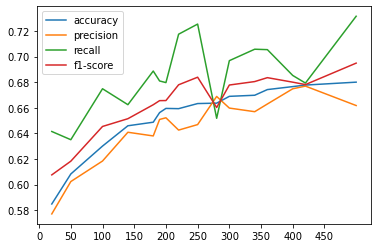

In [28]:
D = [20,50,100,140,180,190,200,220,250,280,300,340,360,400,420,500]

plot_dim(D)